In [1]:
import tensorflow as tf
import os

In [2]:
ROOT = os.getcwd()
TENSORFLOW_FOLDER = os.path.join(ROOT, 'TensorFlow')
TRAINING_DEMO_FOLDER = os.path.join(TENSORFLOW_FOLDER, 'workspace', 'training_demo')
IMAGES_FOLDER = os.path.join(TRAINING_DEMO_FOLDER, 'images')
TRAIN_FILE = os.path.join(IMAGES_FOLDER, 'train')
TEST_FILE = os.path.join(IMAGES_FOLDER, 'test')
ANNOTATIONS_FOLDER = os.path.join(TRAINING_DEMO_FOLDER, 'annotations')
LABEL_MAP_FILE = os.path.join(ANNOTATIONS_FOLDER, 'label_map.pbtxt')
TRAIN_RECORD_FILE = os.path.join(ANNOTATIONS_FOLDER, 'train.record')
TEST_RECORD_FILE = os.path.join(ANNOTATIONS_FOLDER, 'test.record')
MODELS_FOLDER = os.path.join(TRAINING_DEMO_FOLDER, 'models')
CHECKPOINT_FOLDER = os.path.join(MODELS_FOLDER, 'ssd_mobilenet_v2_fpn')
PIPELINE_FILE = os.path.join(CHECKPOINT_FOLDER, 'pipeline.config')

In [26]:
# Create train data:
!python generate_tfrecord.py -x {TRAIN_FILE} -l {LABEL_MAP_FILE} -o {TRAIN_RECORD_FILE}

# Create test data:
!python generate_tfrecord.py -x {TEST_FILE} -l {LABEL_MAP_FILE} -o {TEST_RECORD_FILE}


Successfully created the TFRecord file: C:\Users\kok19\Desktop\Krish_CV\TensorFlow\workspace\training_demo\annotations\train.record
Successfully created the TFRecord file: C:\Users\kok19\Desktop\Krish_CV\TensorFlow\workspace\training_demo\annotations\test.record


**Train the model**

In [ ]:
python model_main_tf2.py --model_dir=models/ssd_mobilenet_v2_fpn --pipeline_config_path=models/ssd_mobilenet_v2_fpn/pipeline.config

**Evaluate Model**

In [21]:
command = f"python model_main_tf2.py --model_dir={CHECKPOINT_FOLDER} --pipeline_config_path={PIPELINE_FILE} --checkpoint_dir={CHECKPOINT_FOLDER}"

In [22]:
print(command)

python model_main_tf2.py --model_dir=C:\Users\kok19\Desktop\Krish_CV\TensorFlow\workspace\training_demo\models\ssd_mobilenet_v2_fpn --pipeline_config_path=C:\Users\kok19\Desktop\Krish_CV\TensorFlow\workspace\training_demo\models\ssd_mobilenet_v2_fpn\pipeline.config --checkpoint_dir=C:\Users\kok19\Desktop\Krish_CV\TensorFlow\workspace\training_demo\models\ssd_mobilenet_v2_fpn


In [ ]:
# View with tensorboard
# cd ./models/model_name/train
# tensorboard --logdir=.

**Export model**

In [ ]:
command = python exporter_main_v2.py --input_type image_tensor --pipeline_config_path models/ssd_mobilenet_v2_fpn/pipeline.config --trained_checkpoint_dir models/ssd_mobilenet_v2_fpn --output_directory exported-models/my_model

**Load train model from checkpoint**

In [3]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [4]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PIPELINE_FILE)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_FOLDER, 'ckpt-4')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

**Detect from Image**

In [5]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_FILE)

In [7]:
IMAGE_PATH = os.path.join(TEST_FILE, 'WIN_20210504_13_37_26_Pro.jpg')

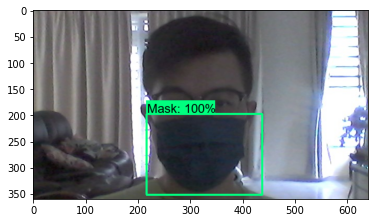

In [9]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.9,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

**Real time detection from webcam**

In [11]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break